In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver

Copyright (c) 2005-2022 NVIDIA Corporation

Built on Wed_Sep_21_10:33:58_PDT_2022

Cuda compilation tools, release 11.8, V11.8.89

Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
# !pip install torch torchvision
# !pip install --upgrade tensorflow-gpu


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
import torch
import tensorflow as tf
# Set up the device
with tf.device('/GPU:0'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

print("all libraries were successfully installed!!")

all libraries were successfully installed!!


In [ ]:


# Preprocessing the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5


In [ ]:
print(x_train.shape)

(50000, 32, 32, 3)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(256)

### BUILDING BOTH GENERATOR AND DISCRIMINATOR

In [ ]:
# Define generator and discriminator networks

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[32, 32, 3])) #2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              409600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       2

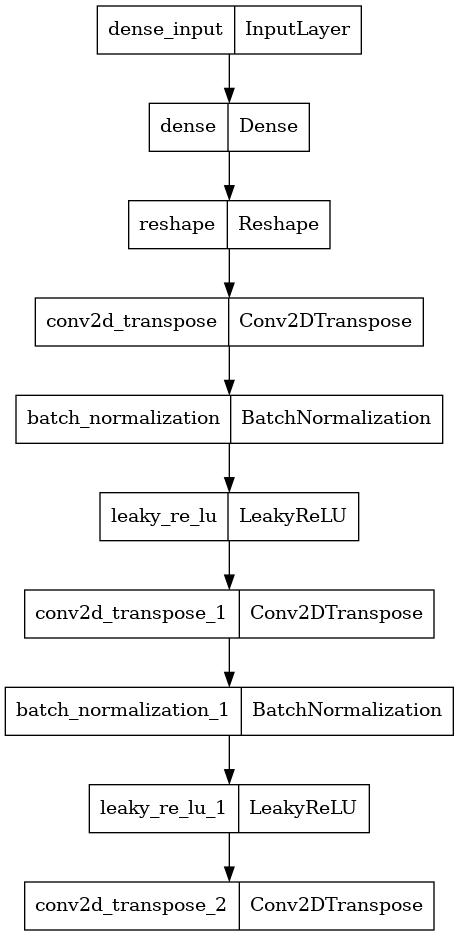

In [ ]:
tf.keras.utils.plot_model(generator, "/kaggle/working/generator_arch.png")

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

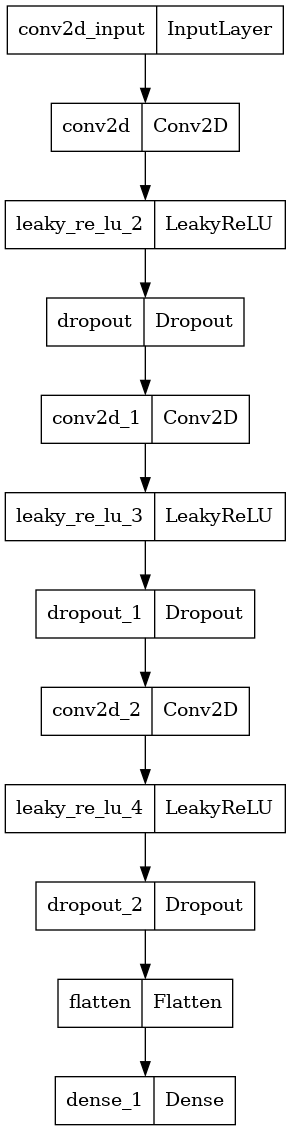

In [ ]:
tf.keras.utils.plot_model(discriminator, "/kaggle/working/discriminator_arch.png")

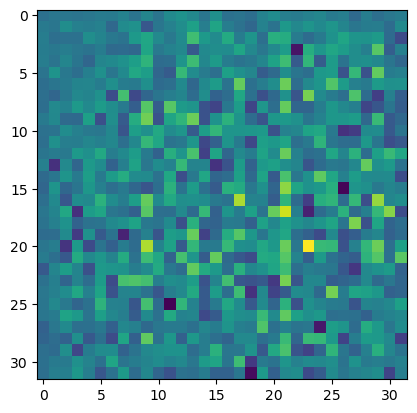

In [ ]:
# sample image generated by the the generator

generator = make_generator_model()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## Defining the optimizers for both generator and discriminator


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# def generator_loss(fake_output):
#     return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
#     fake_loss = tf.keras.losses

In [ ]:
# Initializing the losses for both networks
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
import os
os.makedirs('/kaggle/working/generated_images')

/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"
2023-04-26 17:34:47.157728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-26 17:35:11.246772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


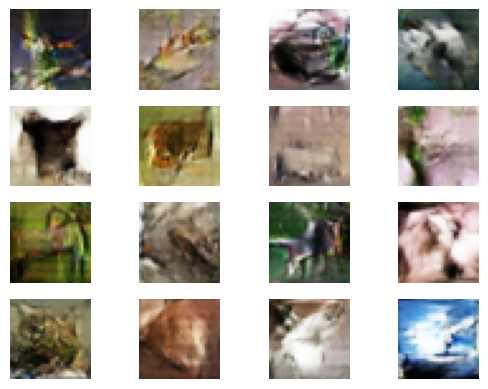

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    global discr_loss, gener_loss
    gener_loss=[]
    discr_loss=[]
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      gener_loss.append(gen_loss)
      discr_loss.append(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Train the model
EPOCHS = 1000
LATENT_DIM = 100
BATCH_SIZE = 256

for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)

    if epoch % 10 == 0:
        # Generate and save sample images
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images * 127.5) + 127.5
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i].numpy().astype('int'))
            plt.axis('off')
        plt.savefig(f'/kaggle/working/generated_images/generated_images_{epoch}.png')

        


In [ ]:

# # Plot the generator and discriminator loss values vs. epochs
# plt.plot(range(NUM_EPOCHS), generator_losses, label='Generator loss')
# plt.plot(range(NUM_EPOCHS), discriminator_losses, label='Discriminator loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [ ]:
# Save the generator and discriminator models
tf.saved_model.save(generator, 'generator_model')
tf.saved_model.save(discriminator, 'discriminator_model')

In [ ]:
generator.save("/kaggle/working/generator.h5")

In [ ]:
discriminator.save("/kaggle/working/discriminator.h5")

## Loading the model

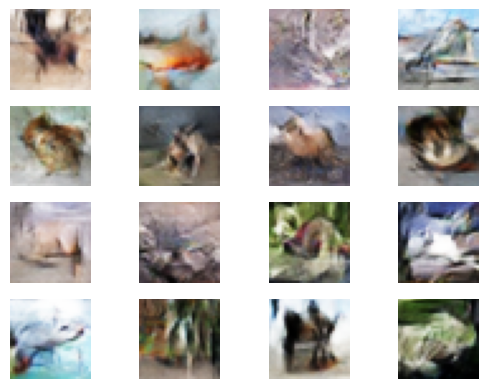

In [ ]:
# Load the generator model
MODEL_GEN = tf.saved_model.load('/kaggle/working/generator_model')

# Generate new images
noise = tf.random.normal([16, LATENT_DIM])
generated_images = MODEL_GEN(noise, training=False)
generated_images = (generated_images * 127.5) + 127.5
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].numpy().astype('int'))
    plt.axis('off')
plt.show()


In [ ]:
import shutil
shutil.make_archive("generated_images", 'zip', '/kaggle/working/generated_images')

'/kaggle/working/generated_images.zip'

In [ ]:
# import os 
# os.chdir(r'/kaggle/working')

In [ ]:
# from IPython.display import FileLinks
# FileLinks(r'/kaggle/working/generator_model')